In [1]:
# autoreload
%load_ext autoreload
%autoreload 2

# Generate Synthetic Data

In [252]:
import numpy as np
import tqdm
import matplotlib.pyplot as plt


def generate_random_skewed_data(B, N):
    p = np.linspace(0, 1, B) ** 2
    D = np.random.choice(B, N, p=p / np.sum(p))
    return D


def generate_random_uniform_data(B, N):
    D = np.random.choice(B, N)
    return D

def generate_pareto_data(shape, N, scale=2000):
    D = np.random.pareto(shape, N) * scale
    return D

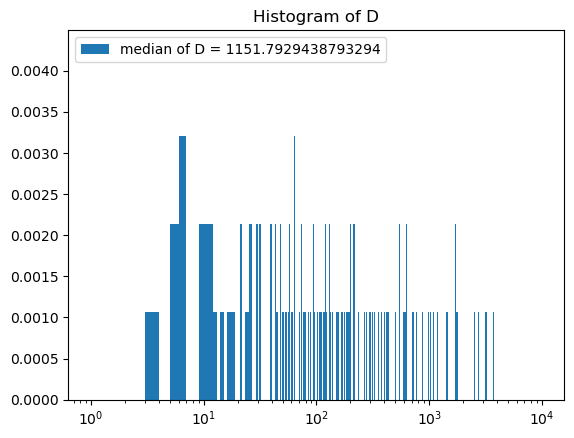

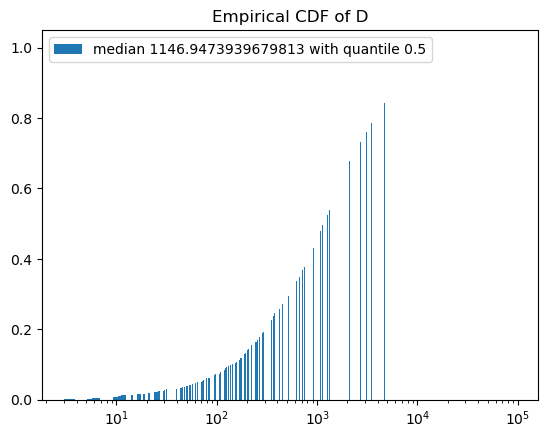

In [203]:
# B_max = 10000
# B = np.arange(1, B_max + 1)
# intervals = np.array([B[:-1], B[1:]]).T
N = 1000

data = generate_pareto_data(1.5, N)

# plot histogram of D
plt.hist(data, bins=B, label=f"median of D = {np.median(data)}", density=True)
plt.xscale('log')
plt.title('Histogram of D')
plt.legend()
plt.show()

# compute the empirical cumulative distribution function of D
from scipy.stats import ecdf

cf = ecdf(data)
cf_dict = dict(zip(cf.cdf.quantiles, cf.cdf.probabilities))
median = cf.cdf.quantiles[cf.cdf.probabilities >= 0.5][0]
# plot the empirical cumulative distribution function of D
plt.bar(cf.cdf.quantiles, cf.cdf.probabilities, label=f'median {median} with quantile {cf_dict[median]}')
plt.xscale('log')
plt.title('Empirical CDF of D')
plt.legend()
plt.show()

# Discretize data

In [247]:
num_bins = int(1E3)  # Number of bins
max_value = 1E6
bins = np.linspace(0, int(max_value), num_bins + 1)  # Bin edges
intervals = np.array([bins[:-1], bins[1:]]).T

# Import algorithms

In [227]:
from DP_GPNBS.median_selection import median_bayesian_screening_search
from test.noisy_binary_search import noisy_binary_search

# Epsilon = 1

In [248]:
num_experiments = 100
M = len(data)
replacement = False
eps = 1
alphas = [0.01, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13, 0.15, 0.17, 0.19]
success_1 = np.zeros((len(alphas), num_experiments))
for a, alpha in tqdm.tqdm(enumerate(alphas)):
    for i in range(num_experiments):
        D = list(data)
        output = noisy_binary_search(D=D, intervals=intervals, alpha=alpha, eps=eps, M=M, replacement=replacement)
        # check if output is correct
        if output in cf_dict.keys():
            quantile_output = cf_dict[output]
        else:
            # find the higher value in the dictionary smaller than output
            if output >= min(cf_dict.keys()):
                quantile_output = cf_dict[max([x for x in cf_dict.keys() if x <= output])]
            else:
                quantile_output = 0
        if 0.5 - alpha < quantile_output < 0.5 + alpha:
            success_1[a][i] = 1
        else:
            success_1[a][i] = 0

10it [00:07,  1.30it/s]


In [249]:
num_experiments = 100
M = len(data)
replacement = False
eps = 1
alphas = [0.01, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13, 0.15, 0.17, 0.19]
success_2 = np.zeros((len(alphas), num_experiments))
for a, alpha in tqdm.tqdm(enumerate(alphas)):
    for i in range(num_experiments):
        D = list(data)
        output = median_bayesian_screening_search(D=D, intervals=intervals, alpha=alpha, eps=eps, M=M,
                                                  replacement=replacement)
        # check if output is correct
        if output in cf_dict.keys():
            quantile_output = cf_dict[output]
        else:
            # find the higher value in the dictionary smaller than output
            if output >= min(cf_dict.keys()):
                quantile_output = cf_dict[max([x for x in cf_dict.keys() if x <= output])]
            else:
                quantile_output = 0
        if 0.5 - alpha < quantile_output < 0.5 + alpha:
            success_2[a][i] = 1
        else:
            success_2[a][i] = 0

10it [00:19,  1.91s/it]


In [250]:
from scipy.stats import bootstrap
def get_mean_CI(data, alpha=0.9):
    average = np.mean(data, axis=1)
    confidence_interval = []
    for i in range(len(average)):
        if np.std(data[i]) > 0:
            res = bootstrap((data[i],), np.mean, confidence_level=alpha)
            confidence_interval.append(res.confidence_interval)
        else:
            confidence_interval.append((average[i], average[i]))
    error = np.array(confidence_interval)
    for i in range(error.shape[0]):
        error[i][0] = np.clip(average[i] - error[i][0], 0, 1)
        error[i][1] = np.clip(error[i][1] - average[i], 0, 1)
    error = error.T
    return average, error

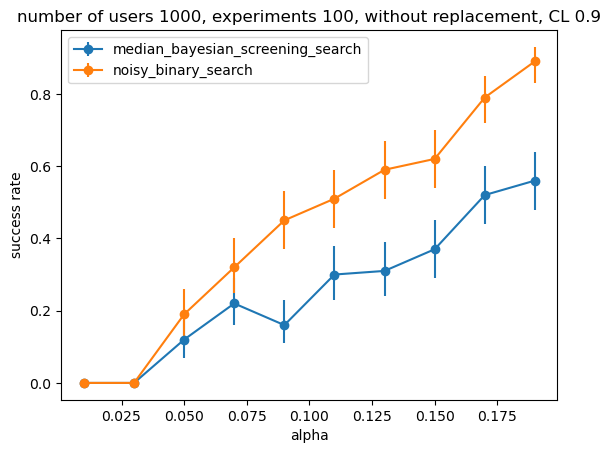

In [251]:
from scipy.stats import bootstrap

# plot success rate mean and std for each alpha
success_rate_1, error_1 = get_mean_CI(success_1, 0.9)
success_rate_2, error_2 = get_mean_CI(success_2, 0.9)
# plot using confidence interval
plt.errorbar(alphas, success_rate_2, yerr=error_2, fmt='-o', label='median_bayesian_screening_search')
plt.errorbar(alphas, success_rate_1, yerr=error_1, fmt='-o', label='noisy_binary_search')
plt.xlabel('alpha')
plt.ylabel('success rate')
plt.title(f'number of users {N}, experiments {num_experiments}, without replacement, CL 0.9')
plt.legend()
# save in figures
# plt.savefig('figures/success_rate_alpha_1.png')
plt.show()

## get an alpha interval for probability higher than 0.85

In [112]:
# take alpha with success rate higher than 0.9
alpha_1 = alphas[np.where(success_rate_1 - error_1[0,:] > 0.85)[0][0]]
alpha_2 = alphas[np.where(success_rate_2 - error_2[0,:] > 0.85)[0][0]]

In [113]:
alpha_1

0.11

# Noisy Binary Search

In [138]:
def get_low_error(data, alpha=0.9):
    confidence_interval = []
    if np.std(data) > 0:
        res = bootstrap((data,), np.mean, confidence_level=alpha)
        confidence_interval.append(res.confidence_interval)
    else:
        confidence_interval.append((data[i], data[i]))
    error = np.array(confidence_interval).flatten()
    return error[0]

In [157]:
num_experiments = 50
trials = 10
M = len(data)
replacement = False
eps_list = [0.1, 0.5, 1, 5, 10]
alphas = [0.49, 0.47, 0.45, 0.43, 0.41, 0.39, 0.37, 0.35, 0.33, 0.31, 0.29, 0.27, 0.25, 0.23, 0.21, 0.19, 0.17, 0.15, 0.13, 0.11, 0.09, 0.07, 0.05, 0.03, 0.01]
alphas_reverse = alphas[::-1]
max_alpha_noisy = np.zeros((len(eps_list), trials))
# min_alpha_noisy = np.zeros(len(eps_list))
for k, eps in tqdm.tqdm(enumerate(eps_list)):
    for t in range(trials):
        success = np.zeros(num_experiments)
        for a, alpha in enumerate(alphas):
            for i in range(num_experiments):
                D = list(data)
                output = median_bayesian_screening_search(D=D, intervals=intervals, alpha=alpha, eps=eps, M=M, replacement=replacement)
                # check if output is correct
                if output in cf_dict.keys():
                    quantile_output = cf_dict[output]
                else:
                    # find the higher value in the dictionary smaller than output
                    if output >= min(cf_dict.keys()):
                        quantile_output = cf_dict[max([x for x in cf_dict.keys() if x <= output])]
                    else:
                        quantile_output = 0
                if 0.5 - alpha < quantile_output < 0.5 + alpha:
                    success[i] = 1
                else:
                    success[i] = 0
            low_error = get_low_error(success, 0.9)
            # print(low_error)
            if low_error < 0.85:
                print(f'eps {eps} max alpha {alpha}')
                max_alpha_noisy[k][t] = alpha
                break
            
    # success = np.zeros(num_experiments)
    # for a, alpha in tqdm.tqdm(enumerate(alphas_reverse)):
    #     for i in range(num_experiments):
    #         D = list(data)
    #         output = median_bayesian_screening_search(D=D, intervals=intervals, alpha=alpha, eps=eps, M=M, replacement=replacement)
    #         # check if output is correct
    #         if output in cf_dict.keys():
    #             quantile_output = cf_dict[output]
    #         else:
    #             # find the higher value in the dictionary smaller than output
    #             if output >= min(cf_dict.keys()):
    #                 quantile_output = cf_dict[max([x for x in cf_dict.keys() if x <= output])]
    #             else:
    #                 quantile_output = 0
    #         if 0.5 - alpha < quantile_output < 0.5 + alpha:
    #             success[i] = 1
    #         else:
    #             success[i] = 0
    #     low_error = get_low_error(success, 0.9)
    #     # print(low_error)
    #     if low_error > 0.85:
    #         print(f'eps {eps} min alpha {alpha}')
    #         min_alpha_noisy[k] = alpha
    #         break 
    #     else:
    #         min_alpha_noisy[k] = max_alpha_noisy[k]

0it [00:00, ?it/s]

eps 0.1 max alpha 0.49
eps 0.1 max alpha 0.49
eps 0.1 max alpha 0.49
eps 0.1 max alpha 0.49
eps 0.1 max alpha 0.49
eps 0.1 max alpha 0.49
eps 0.1 max alpha 0.49
eps 0.1 max alpha 0.49
eps 0.1 max alpha 0.49


1it [00:25, 25.93s/it]

eps 0.1 max alpha 0.49
eps 0.5 max alpha 0.49
eps 0.5 max alpha 0.47
eps 0.5 max alpha 0.45
eps 0.5 max alpha 0.47
eps 0.5 max alpha 0.49
eps 0.5 max alpha 0.47
eps 0.5 max alpha 0.47
eps 0.5 max alpha 0.45
eps 0.5 max alpha 0.47


2it [01:20, 42.60s/it]

eps 0.5 max alpha 0.45
eps 1 max alpha 0.11
eps 1 max alpha 0.07
eps 1 max alpha 0.07
eps 1 max alpha 0.11
eps 1 max alpha 0.07
eps 1 max alpha 0.11
eps 1 max alpha 0.07
eps 1 max alpha 0.13
eps 1 max alpha 0.07


3it [10:28, 273.49s/it]

eps 1 max alpha 0.09
eps 5 max alpha 0.01
eps 5 max alpha 0.01
eps 5 max alpha 0.01
eps 5 max alpha 0.01
eps 5 max alpha 0.01
eps 5 max alpha 0.01
eps 5 max alpha 0.01
eps 5 max alpha 0.01
eps 5 max alpha 0.01


4it [21:19, 422.53s/it]

eps 5 max alpha 0.01
eps 10 max alpha 0.01
eps 10 max alpha 0.01
eps 10 max alpha 0.01
eps 10 max alpha 0.01
eps 10 max alpha 0.01
eps 10 max alpha 0.01
eps 10 max alpha 0.01
eps 10 max alpha 0.01
eps 10 max alpha 0.01


5it [32:10, 386.08s/it]

eps 10 max alpha 0.01


# Median Bayesian Screening Search

In [143]:
num_experiments = 100
M = len(data)
replacement = False
eps_list = [0.1, 0.5, 1, 5, 10]
alphas = [0.49, 0.47, 0.45, 0.43, 0.41, 0.39, 0.37, 0.35, 0.33, 0.31, 0.29, 0.27, 0.25, 0.23, 0.21, 0.19, 0.17, 0.15, 0.13, 0.11, 0.09, 0.07, 0.05, 0.03, 0.01]
alphas_reverse = alphas[::-1]
min_alpha_bayes = np.zeros(len(eps_list))
max_alpha_bayes = np.zeros(len(eps_list))
for k, eps in enumerate(eps_list):
    success = np.zeros(num_experiments)
    for a, alpha in tqdm.tqdm(enumerate(alphas)):
        for i in range(num_experiments):
            D = list(data)
            output = median_bayesian_screening_search(D=D, intervals=intervals, alpha=alpha, eps=eps, M=M, replacement=replacement)
            # check if output is correct
            if output in cf_dict.keys():
                quantile_output = cf_dict[output]
            else:
                # find the higher value in the dictionary smaller than output
                if output >= min(cf_dict.keys()):
                    quantile_output = cf_dict[max([x for x in cf_dict.keys() if x <= output])]
                else:
                    quantile_output = 0
            if 0.5 - alpha < quantile_output < 0.5 + alpha:
                success[i] = 1
            else:
                success[i] = 0
        low_error = get_low_error(success, 0.9)
        # print(low_error)
        if low_error < 0.85:
            print(f'eps {eps} alpha {alpha}')
            max_alpha_bayes[k] = alpha
            break
            
    success = np.zeros(num_experiments)
    for a, alpha in tqdm.tqdm(enumerate(alphas_reverse)):
        for i in range(num_experiments):
            D = list(data)
            output = median_bayesian_screening_search(D=D, intervals=intervals, alpha=alpha, eps=eps, M=M, replacement=replacement)
            # check if output is correct
            if output in cf_dict.keys():
                quantile_output = cf_dict[output]
            else:
                # find the higher value in the dictionary smaller than output
                if output >= min(cf_dict.keys()):
                    quantile_output = cf_dict[max([x for x in cf_dict.keys() if x <= output])]
                else:
                    quantile_output = 0
            if 0.5 - alpha < quantile_output < 0.5 + alpha:
                success[i] = 1
            else:
                success[i] = 0
        low_error = get_low_error(success, 0.9)
        # print(low_error)
        if low_error > 0.85:
            print(f'eps {eps} alpha {alpha}')
            min_alpha_bayes[k] = alpha
            break 
        else:
            min_alpha_noisy[k] = max_alpha_noisy[k]

0it [00:05, ?it/s]


eps 0.1 alpha 0.49


4it [00:25,  6.49s/it]


eps 0.5 alpha 0.41


22it [02:00,  5.49s/it]


eps 1 alpha 0.05


24it [02:10,  5.45s/it]


eps 5 alpha 0.01


24it [02:10,  5.45s/it]

eps 10 alpha 0.01


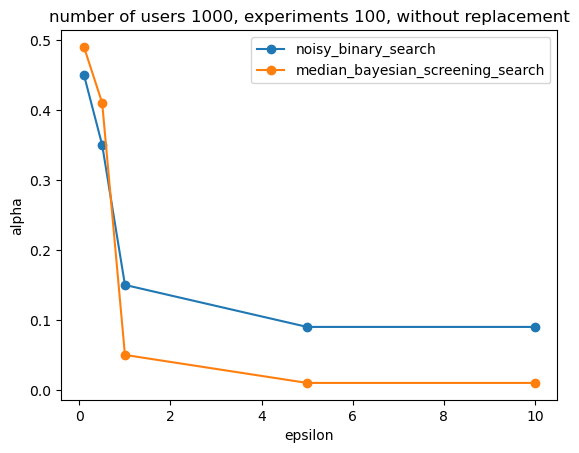

In [146]:
# plot min alpha for noisy binary search and median bayesian screening search
plt.plot(eps_list, min_alpha_noisy, '-o', label='noisy_binary_search')
plt.plot(eps_list, min_alpha_bayes, '-o', label='median_bayesian_screening_search')
plt.xlabel('epsilon')
plt.ylabel('alpha')
plt.title(f'number of users {N}, experiments {num_experiments}, without replacement')
plt.legend()
plt.savefig('figures/min_alpha_eps.png')
plt.show()

In [147]:
alphas_reverse = alphas[::-1]

In [148]:
alphas_reverse

[0.01,
 0.03,
 0.05,
 0.07,
 0.09,
 0.11,
 0.13,
 0.15,
 0.17,
 0.19,
 0.21,
 0.23,
 0.25,
 0.27,
 0.29,
 0.31,
 0.33,
 0.35,
 0.37,
 0.39,
 0.41,
 0.43,
 0.45,
 0.47,
 0.49]